# Bone age prediction of hand radiographs using Neural Networks

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import time

import matplotlib as mpl
# setting some matplotlib parameters for plots
mpl.rcParams['figure.figsize'] = (15, 15)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams.update({'font.size': 22})


%matplotlib inline
np.random.seed(1)

IMG_SIZE = 224
batch_size = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 1)

In [3]:
# cmap = mpl.cm.get_cmap('plasma')
cmap = mpl.cm.get_cmap('viridis')

colors = [cmap(0.0), cmap(0.25), cmap(0.5), cmap(0.75)]
print(colors)

[(0.267004, 0.004874, 0.329415, 1.0), (0.229739, 0.322361, 0.545706, 1.0), (0.127568, 0.566949, 0.550556, 1.0), (0.369214, 0.788888, 0.382914, 1.0)]


## Retrieve datasets

In [4]:
import os
import zipfile

# Define the data folder location
path = '/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/'
data_dirs = ['Bone Age Training Set', 'Bone Age Validation Set','Bone Age Test Set']
train_dirs = ['boneage-training-dataset', 'dataset_data_file_training-gt-6aaa9791-5bdc-4c6d-9ee9-5a3780a37103']
val_dirs = ['boneage-validation-dataset-1', 'boneage-validation-dataset-2']

train_path = path + 'data/Bone Age Training Set/'
val_path = path + 'data/Bone Age Validation Set/'
test_path = path + 'data/Bone Age Test Set/'
masks_path = path + 'all_training_masks/'
masked_path = path + 'boneage-training-dataset-masked/'

In [5]:
with zipfile.ZipFile(path + 'boneage-training-dataset-masked.zip', 'r') as f:
  f.extractall('.')

In [6]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/data/Bone Age Validation Set/boneage-validation-dataset-masked' 'boneage-validation-dataset-masked'

In [7]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/data/Bone Age Test Set/boneage-test-dataset-masked' 'boneage-test-dataset-masked'

In [22]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/data/Bone Age Test Set/boneage-test-dataset-masked2' 'boneage-test-dataset-masked2'

In [ ]:
# with zipfile.ZipFile(val_path + val_dirs[0] + '.zip', 'r') as f:
#   f.extractall('.')
# with zipfile.ZipFile(val_path + val_dirs[1] + '.zip', 'r') as f:
#   f.extractall('.')

In [ ]:
# with zipfile.ZipFile(path + 'Bone Age Test Set.zip') as f:
#   f.extractall('.')

In [ ]:
# # Extract data from zip file
# for data_dir in data_dirs:
#   if not os.path.exists(data_dir):
#   # if not os.path.exists(path + 'data/' + data_dir):
#     with zipfile.ZipFile(path + data_dir + '.zip', 'r') as f:
#       f.extractall('.')
#       # f.extractall(path + 'data')
#   if 'Training' in data_dir: # training set has two more zip files
#     for train_dir in train_dirs:
#       if not os.path.exists(train_dir):
#         with zipfile.ZipFile(data_dir + '/' + train_dir + '.zip', 'r') as f:
#           f.extractall('.')
#       # if not os.path.exists(path + 'data/' + data_dir + '/' + train_dir):
#       #   with zipfile.ZipFile(path + 'data/' + data_dir + '/' + train_dir + '.zip', 'r') as f:
#       #     f.extract(path + data_dir)
#   if 'Validation' in data_dir: # validation set is divided in two more zip files
#     for val_dir in val_dirs:
#       if not os.path.exists(val_dir):
#         with zipfile.ZipFile(data_dir + '/' + val_dir + '.zip', 'r') as f:
#           f.extractall('.')
#       # if not os.path.exists(path + 'data/' + data_dir + '/' + val_dir):
#       #   with zipfile.ZipFile(path + 'data/' + data_dir + '/' + val_dir + '.zip', 'r') as f:
#       #     f.extractall(path + 'data/' + data_dir)

In [ ]:
# !cp -R /content/boneage-training-dataset /content/boneage-training-masked
# !mkdir /content/boneage_training_masked
# !rm -r "/content/Bone Age Training Set"
# !mv "/content/Bone Age Validation Set/Validation Dataset.csv" /content
# !rm -r "/content/Bone Age Validation Set"

## Creating dataframes

In [8]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/utils.py" utils.py
from utils import *

train_df = load_filenames(train_path + 'train.csv', train_path + train_dirs[0])
validation_df = load_filenames(val_path + '/Validation Dataset.csv', val_path + val_dirs[0], val_path + val_dirs[1])
test_df = load_filenames(test_path + '/Bone age ground truth.xlsx', test_path + 'Bone Age Test Set/Test Set Images')

# normalize boneage value to accelerate training
mean_bone_age = train_df['boneage'].mean()
std_bone_age = train_df['boneage'].std()
train_df['boneage_n'] = (train_df['boneage'] - mean_bone_age) / std_bone_age
validation_df['boneage_n'] = (validation_df['boneage'] - mean_bone_age) / std_bone_age
test_df['boneage_n'] = (test_df['boneage'] - mean_bone_age) / std_bone_age

# number of steps between epochs
train_steps = int(np.ceil(train_df.shape[0] / batch_size))
val_steps = int(np.ceil(validation_df.shape[0] / batch_size))

In [9]:
display(train_df.head(3))
display(validation_df.head(3))
display(test_df.head(3))

,image,gender(M/F),boneage,boneage_n
0,/content/drive/My Drive/Colab Notebooks/Human ...,0,180,1.279181
1,/content/drive/My Drive/Colab Notebooks/Human ...,0,12,-2.800269
2,/content/drive/My Drive/Colab Notebooks/Human ...,0,94,-0.809109


,image,gender(M/F),boneage,boneage_n
0,/content/drive/My Drive/Colab Notebooks/Human ...,0,30,-2.363185
1,/content/drive/My Drive/Colab Notebooks/Human ...,1,162,0.842097
2,/content/drive/My Drive/Colab Notebooks/Human ...,0,18,-2.654575


,image,gender(M/F),boneage,boneage_n
0,/content/drive/My Drive/Colab Notebooks/Human ...,1,168.934249,1.010477
1,/content/drive/My Drive/Colab Notebooks/Human ...,1,169.652678,1.027922
2,/content/drive/My Drive/Colab Notebooks/Human ...,1,73.256112,-1.312821


## Preprocessing

### contrast enhancement and normalization

In [ ]:
# def ce_norm(df, new_path, factor=2.5):
#   func = lambda p: tf.keras.preprocessing.image.save_img(new_path + p.split('/')[-1], 
#                                                          image_contrast_enhancement(normalize_values(cv2.imread(p)), factor=factor))
#   df['image'].apply(func)
#   df['image'] = df['image'].map(lambda p: new_path + p.split('/')[-1])

# ce_norm(train_df, train_path + 'Train Set Images Contrast/')
# ce_norm(validation_df, val_path + 'Validation Set Images Contrast/', factor=1.5)
# ce_norm(test_df, test_path + 'Test Set Images Contrast/')

### apply masks

In [ ]:
# mask_model = tf.keras.models.load_model(path + 'Unet100epochs_trainable={}_contrast.h5'.format('True'), compile=False)

In [ ]:
# def apply_masking(df, batch_size, path):
#   original_names = df['image']
#   load_img = lambda file_name : (file_name.split('/')[-1], normalize_values(load_hand_image(file_name, IMG_SIZE)))
#   original_imgs = original_names.map(load_img)
#   for elem in original_imgs:
#     name, img = elem
#     pred = mask_model.predict(np.repeat(np.expand_dims(img, axis=0), batch_size, axis=0))
#     tf.keras.preprocessing.image.save_img(path + name, pred[0])

# apply_masking(validation_df, batch_size, "val_masks/")
# apply_masking(test_df, batch_size, "test_masks/")

In [ ]:
# apply_masks(train_df, masks_path, IMG_SIZE, train_df.shape[0], masked_path)
# apply_masks(validation_df, val_path + 'val_masks/', IMG_SIZE, validation_df.shape[0], val_path + 'boneage-validation-dataset-masked/')
# apply_masks(test_df, test_path + 'test_masks/', IMG_SIZE, test_df.shape[0], test_path + 'boneage-test-dataset-masked/')

In [10]:
train_df['image'] = train_df['image'].map(lambda p: 'boneage-training-dataset-masked/' + p.split('/')[-1])
validation_df['image'] = validation_df['image'].map(lambda p: 'boneage-validation-dataset-masked/' + p.split('/')[-1])
test_df['image'] = test_df['image'].map(lambda p: 'boneage-test-dataset-masked/' + p.split('/')[-1])

Visualize mask results

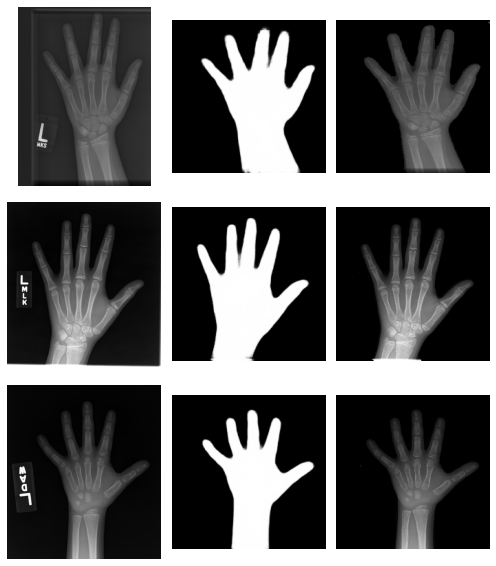

In [11]:
# fig, axs = plt.subplots(3, 3, figsize=(7, 8))
# [ax.axis('off') for ax in axs.flatten()]

# indexes = np.random.randint(0, train_df.shape[0], size=3)
# for ind, (ax1, ax2, ax3) in zip(indexes, axs):
#   name = train_df.loc[ind, 'image'].split('/')[-1]
#   original = cv2.imread(train_path + train_dirs[0] + '/' + name)
#   mask = cv2.imread(path + 'all_training_masks/' + name)
#   masked = cv2.imread(train_df.loc[ind, 'image'])

#   ax1.imshow(original)
#   ax2.imshow(mask)
#   ax3.imshow(masked)

# plt.tight_layout()

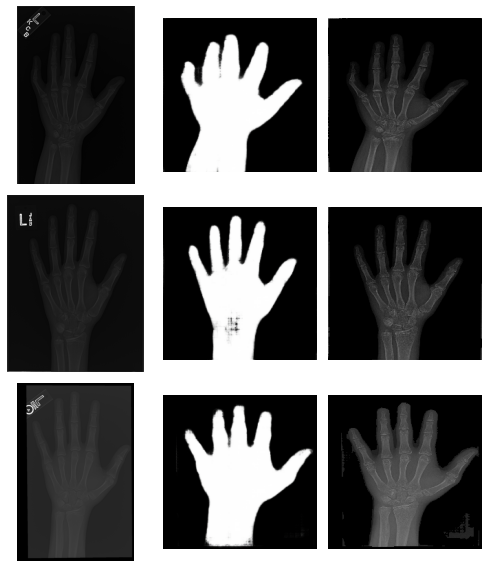

In [12]:
# fig, axs = plt.subplots(3, 3, figsize=(7, 8))
# [ax.axis('off') for ax in axs.flatten()]

# indexes = np.random.randint(0, test_df.shape[0], size=3)
# for ind, (ax1, ax2, ax3) in zip(indexes, axs):
#   name = test_df.loc[ind, 'image'].split('/')[-1]
#   original = cv2.imread(test_path + 'Test Set Images/' + name)
#   mask = cv2.imread(test_path + 'test_masks/' + name)
#   masked = cv2.imread(test_df.loc[ind, 'image'])

#   ax1.imshow(original)
#   ax2.imshow(mask)
#   ax3.imshow(masked)

# plt.tight_layout()

### With CLAHE

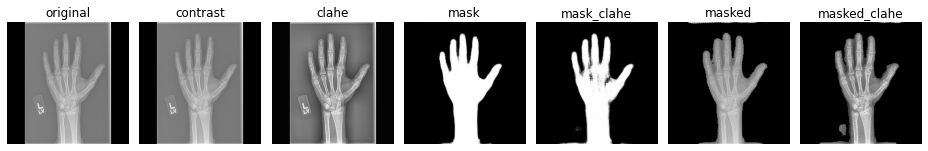

In [29]:
fig, axs = plt.subplots(1, 7, figsize=(13, 17))
[ax.axis('off') for ax in axs.flatten()]

ind = np.random.randint(0, test_df.shape[0])
name = test_df.loc[ind, 'image'].split('/')[-1]
original = cv2.imread(test_path + 'Test Set Images/' + name)
contrast = cv2.imread(test_path + 'Test Set Images Contrast/' + name)
clahe = cv2.imread(test_path + 'test_contrast/' + name)
mask = cv2.imread(test_path + 'test_masks/' + name)
mask_clahe = cv2.imread(test_path + 'test_masks2/' + name)
masked = cv2.imread(test_df.loc[ind, 'image'])
masked_clahe = cv2.imread('boneage-test-dataset-masked2/' + name)

imgs = [original, contrast, clahe, mask, mask_clahe, masked, masked_clahe]
titles = ['original', 'contrast', 'clahe', 'mask', 'mask_clahe', 'masked', 'masked_clahe']

for i, ax in enumerate(axs.flatten()):
  ax.imshow(imgs[i])
  ax.set_title(titles[i])
  
plt.tight_layout()

In [31]:
test_df['image'] = test_df['image'].apply(lambda p: 'boneage-test-dataset-masked2/'+ p.split('/')[-1])

## Data augmentation, Batching, Normalization

In [33]:
datagen_train = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen = gen_2inputs(datagen_train, train_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen = gen_2inputs(datagen_val, validation_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen = gen_2inputs(datagen_test, test_df, IMG_SIZE, test_df.shape[0])

## Models for prediction

In [34]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/models.py" models.py
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/inc_v4.py" inc_v4.py
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/res_net.py" res_net.py
from models import *

epochs = 50

We use the mean absolute error as metric, as suggested in the papers

In [35]:
def mae_in_months(x, y):
    """
    Return mean absolute error in months

    Arguments:
    x -- predicted value
    y -- ground-truth
    """
    mean_bone_age = train_df['boneage'].mean()
    std_bone_age = train_df['boneage'].std()
    return mean_absolute_error((std_bone_age*x + mean_bone_age), (std_bone_age*y + mean_bone_age)) 

Create the callbacks for the fit function

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto',
                                min_delta=0.0001, cooldown=5, min_lr=0.00006)
# csv_logger = CSVLogger('/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/training.log', append=True)

In [ ]:
from keras.callbacks import Callback

class CustomCallback(Callback):
    def __init__(self):
        self.timeref = time.time()
        self.loss = []
        self.val_loss = []
    def on_epoch_end(self, epoch,logs = {}):
        logs['train_time'] = time.time() - self.timeref
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
    def on_train_end(self, logs = {}):
        plt.figure(figsize=(10, 5))
        plt.yscale('log')
        plt.plot(range(len(self.loss)), self.loss, label='Training loss')
        plt.plot(range(len(self.loss)), self.val_loss, label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss Value')
        plt.legend()
        plt.show()

### First place solution

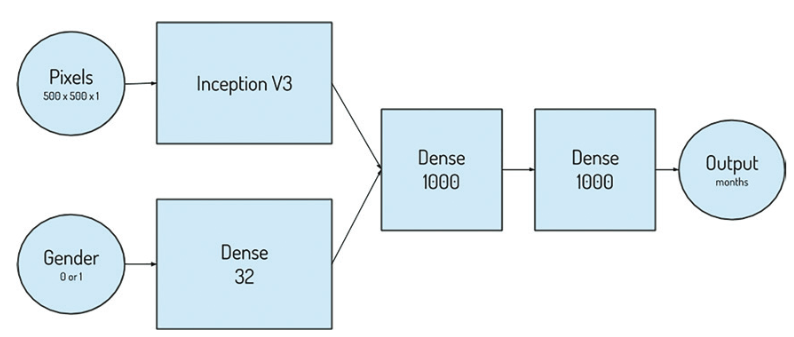

In [ ]:
model_name = 'incV3'
gender = True
weight_path = path + 'models_checkpoints/'+ "{}-newLR_weights.best.hdf5".format(model_name)
optim = tf.keras.optimizers.Adam(learning_rate=0.1)
incV3_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', optim, mae_in_months, with_gender=gender)

In [ ]:
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/training_incV3_newLR.log', append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

incV3_history, incV3_time = fit_boneage(incV3_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, callbacks, gender)

Found 12611 validated image filenames.
Found 12611 validated image filenames.
Epoch 1/50
395/395 [==============================] - ETA: 0s - loss: 638.1763 - mae_in_months: 26281.3965 - accuracy: 0.0000e+00Found 1425 validated image filenames.
Found 1425 validated image filenames.

Epoch 1: val_loss improved from inf to 48.96583, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV3-newLR_weights.best.hdf5
395/395 [==============================] - 175s 398ms/step - loss: 638.1763 - mae_in_months: 26281.3965 - accuracy: 0.0000e+00 - val_loss: 48.9658 - val_mae_in_months: 2016.5120 - val_accuracy: 0.0000e+00 - lr: 0.1000 - train_time: 175.6746
Epoch 2/50
395/395 [==============================] - ETA: 0s - loss: 1.7532 - mae_in_months: 72.2015 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 48.96583 to 1.03263, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/in

KeyboardInterrupt: ignored

In [ ]:
# load the best version of the model
incV3_model.load_weights(weight_path)

### InceptionV4
In this case we took the first-place solution replacing the Inception V3 model with an Inception V4, with the result of concatenating the 32-dimension vector corresponding to the gender with the pixels' vector of 75,264 dimensions (instead of 100,352)

In [ ]:
model_name = 'incV4'
gender = True
incV4_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

In [ ]:
weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
callbacks = [checkpoint, early_stopping, reduce_lr]

epochs = 50

incV4_history, incV4_time = fit_boneage(incV4_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, [checkpoint], gender)

Found 12611 validated image filenames.
Found 12611 validated image filenames.
Epoch 1/50
395/395 [==============================] - ETA: 0s - loss: 0.8238 - mae_in_months: 33.9249 - accuracy: 0.0000e+00Found 1425 validated image filenames.
Found 1425 validated image filenames.

Epoch 1: val_loss improved from inf to 0.83892, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV4_weights.best.hdf5
395/395 [==============================] - 246s 588ms/step - loss: 0.8238 - mae_in_months: 33.9249 - accuracy: 0.0000e+00 - val_loss: 0.8389 - val_mae_in_months: 34.5482 - val_accuracy: 0.0000e+00
Epoch 2/50
395/395 [==============================] - ETA: 0s - loss: 0.6444 - mae_in_months: 26.5357 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 0.83892
395/395 [==============================] - 227s 576ms/step - loss: 0.6444 - mae_in_months: 26.5357 - accuracy: 0.0000e+00 - val_loss: 1.1565 - val_mae_in_months: 47.6274 - 

In [ ]:
incV4_model.load_weights(weight_path)

### Simple CNN
Here we used a simple multi-layer convolution network 


In [ ]:
model_name = 'simple_conv'
gender = True
simple_conv_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

395/395 [==============================] - ETA: 0s - loss: 0.7811 - mae_in_months: 32.1662
Epoch 1: val_loss improved from inf to 0.77388, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/simple_conv_weights.best.hdf5
395/395 [==============================] - 882s 2s/step - loss: 0.7811 - mae_in_months: 32.1662 - val_loss: 0.7739 - val_mae_in_months: 31.8698 - lr: 0.0010


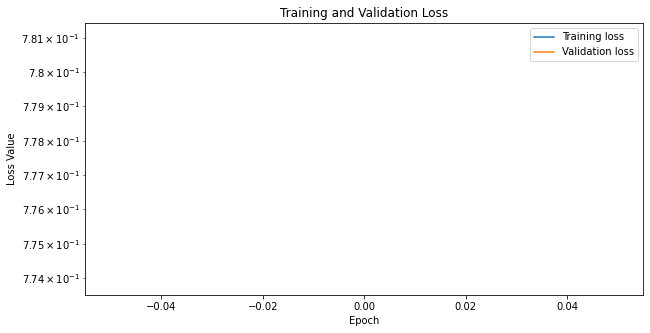

TRAINING FINISHED
Training time: 924.664466381073
Loss: [0.7810739278793335]
MAE in months: [32.16621398925781]
Parameters: 87655737


<Figure size 432x288 with 0 Axes>

In [ ]:
weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
callbacks = [checkpoint, early_stopping, reduce_lr]

simple_conv_history, simple_conv_time = fit_boneage(simple_conv_model, train_gen, train_steps, val_gen, val_steps,
                                                    epochs, callbacks, gender)

In [ ]:
simple_conv_model.load_weights(weight_path)

### VGG16

It seems to be one of the best architectures for image prediction

In [ ]:
model_name = 'vgg16'
gender = True
vgg16_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

In [ ]:
weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
callbacks = [checkpoint, early_stopping, reduce_lr]

vgg16_history, vgg16_time = fit_boneage(vgg16_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, [checkpoint], gender)

In [ ]:
vgg16_model.load_weights(weight_path)

### ResNet50

- try changing from grayscale to rgb
- cut the activation 
- change seed
- reduce LR

In [ ]:
t_df = train_df.copy()
t_df = t_df.append(validation_df.copy())
t_df.shape

(14036, 4)

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(t_df, train_size=0.8)

In [ ]:
print(train.shape, val.shape)

(11228, 4) (2808, 4)


In [ ]:
def gen_2inputs(datagen, df, img_size, batch_size, shuffle=False, seed=None):
    """
    Merge images and gender in a single generator 
    
    Arguments:
    datagen -- ImageDataGenerator used for generating batches of augmented data
    df -- dataframe used to flow data into the generator
    img_size -- size of the images
    batch_size -- size of the training batches
    suffle -- if True generator shuffles the data received
    seed -- required in order to have the same shuffling for image and gender data
    """

    gen_img = datagen.flow_from_dataframe(dataframe=df,
        x_col='image', y_col='boneage_n', batch_size=batch_size, seed=seed, shuffle=shuffle, class_mode='other',
        target_size=(img_size, img_size), color_mode='grayscale', drop_duplicates=False)
    
    gen_gender = datagen.flow_from_dataframe(dataframe=df,
        x_col='image', y_col='gender(M/F)', batch_size=batch_size, seed=seed, shuffle=shuffle, class_mode='other',
        target_size=(img_size, img_size), color_mode='grayscale', drop_duplicates=False)
    
    while True:
        X1i = gen_img.next()
        X2i = gen_gender.next()
        yield [X1i[0], X2i[1]], X1i[1]

In [ ]:
datagen_train = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen = gen_2inputs(datagen_train, train_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen = gen_2inputs(datagen_val, validation_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen = gen_2inputs(datagen_test, test_df, IMG_SIZE, test_df.shape[0])

In [ ]:
from res_net import *
model_name = 'resnet50'
gender = True
weight_path = path + 'models_checkpoints/'+ "{}_weights_26/01.best.hdf5".format(model_name)

optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
resnet_model = create_model(model_name, (IMG_SIZE, IMG_SIZE, 1), 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)
# resnet_model = create_model(model_name, (IMG_SIZE, IMG_SIZE, 3), 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)
# tf.keras.utils.plot_model(resnet_model, show_shapes=True, dpi=64)

In [ ]:
resnet_model.load_weights(weight_path)

In [ ]:
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/training_resnet_26/01.log', append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

resnet_history, resnet_time = fit_boneage(resnet_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, callbacks, gender)

Found 12611 validated image filenames.
Found 12611 validated image filenames.
Epoch 1/50
  2/395 [..............................] - ETA: 1:50:54 - loss: 91.9496 - mae_in_months: 3786.6711 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

## Gender assesment

We want also to see what changes in terms of learning time and accuracy, when the gender data changes.

### No gender

In [ ]:
# reset generators in order to restart from the first batch
# train_gen.reset()
# val_gen.reset()
# test_gen.reset()

# train_gen = gen_2inputs(datagen_train, train_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
# val_gen = gen_2inputs(datagen_val, validation_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
# test_gen = gen_2inputs(datagen_test, test_df, IMG_SIZE, test_df.shape[0])

In [ ]:
model_name = 'incV4'
gender = False
incV4_nogender = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

In [ ]:
weight_path = path + 'models_checkpoints/'+ "{}-gender={}-epochs={}_weights.best.hdf5".format(model_name, gender, epochs)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('training.log', append=True)
callbacks = [checkpoint, CustomCallback(), csv_logger]

incV4_nogender_history, incV4_nogender_time = fit_boneage(incV4_nogender, train_gen, train_steps, val_gen, val_steps,
                                                          epochs, callbacks, gender)

Found 12611 validated image filenames.
Found 12611 validated image filenames.
Epoch 1/50
395/395 [==============================] - ETA: 0s - loss: 0.8652 - mae_in_months: 35.6318 - accuracy: 0.0000e+00Found 1425 validated image filenames.
Found 1425 validated image filenames.

Epoch 1: val_loss improved from inf to 0.83072, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV4-gender=False-epochs=50_weights.best.hdf5
395/395 [==============================] - 251s 575ms/step - loss: 0.8652 - mae_in_months: 35.6318 - accuracy: 0.0000e+00 - val_loss: 0.8307 - val_mae_in_months: 34.2108 - val_accuracy: 0.0000e+00 - train_time: 251.7157
Epoch 2/50
395/395 [==============================] - ETA: 0s - loss: 0.7662 - mae_in_months: 31.5542 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 0.83072
395/395 [==============================] - 222s 562ms/step - loss: 0.7662 - mae_in_months: 31.5542 - accuracy: 0.0000e+00 - va

### Males only

In [ ]:
# filtering new dataframes
train_df_M = train_df[train_df['gender(M/F)'] == 1]
validation_df_M = validation_df[validation_df['gender(M/F)'] == 1]
test_df_M = test_df[test_df['gender(M/F)'] == 1]

# number of steps between epochs
train_steps_M = int(np.ceil(train_df_M.shape[0] / batch_size))
val_steps_M = int(np.ceil(validation_df_M.shape[0] / batch_size))

print(train_df_M.shape[0], validation_df_M.shape[0], test_df_M.shape[0])

6833 773 100


In [ ]:
# new generators
datagen_train_M = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val_M = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test_M = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen_M = gen_2inputs(datagen_train_M, train_df_M, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen_M = gen_2inputs(datagen_val_M, validation_df_M, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen_M = gen_2inputs(datagen_test_M, test_df_M, IMG_SIZE, test_df_M.shape[0])

In [ ]:
model_name = 'incV3'
gender = False
incV3_M = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

Found 6833 validated image filenames.
Found 6833 validated image filenames.
Epoch 1/50
214/214 [==============================] - ETA: 0s - loss: 0.9561 - mae_in_months: 39.3738 - accuracy: 0.0000e+00Found 773 validated image filenames.
Found 773 validated image filenames.

Epoch 1: val_loss improved from inf to 0.79677, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV3-gender=Male-epochs=50_weights.best.hdf5
214/214 [==============================] - 108s 420ms/step - loss: 0.9561 - mae_in_months: 39.3738 - accuracy: 0.0000e+00 - val_loss: 0.7968 - val_mae_in_months: 32.8126 - val_accuracy: 0.0000e+00 - train_time: 108.4074
Epoch 2/50
214/214 [==============================] - ETA: 0s - loss: 0.7491 - mae_in_months: 30.8477 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 0.79677
214/214 [==============================] - 84s 394ms/step - loss: 0.7491 - mae_in_months: 30.8477 - accuracy: 0.0000e+00 - val_loss

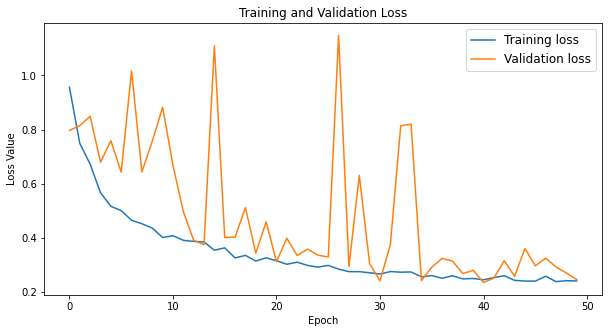

TypeError: ignored

<Figure size 720x360 with 0 Axes>

In [ ]:
weight_path = path + 'models_checkpoints/'+ "{}-gender={}-epochs={}_weights.best.hdf5".format(model_name, 'Male', epochs)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/training_Male.log', append=True)
callbacks = [checkpoint, CustomCallback(), csv_logger]

incV3_M_history, incV3_M_time = fit_boneage(incV3_M, train_gen_M, train_steps_M, val_gen_M, val_steps_M,
                                            epochs, callbacks, 'Male')

### Females only

In [ ]:
# filtering new dataframes
train_df_F = train_df[train_df['gender(M/F)'] == 0]
validation_df_F = validation_df[validation_df['gender(M/F)'] == 0]
test_df_F = test_df[test_df['gender(M/F)'] == 0]

# number of steps between epochs
train_steps_F = int(np.ceil(train_df_F.shape[0] / batch_size))
val_steps_F = int(np.ceil(validation_df_F.shape[0] / batch_size))

print(train_df_F.shape[0], validation_df_F.shape[0], test_df_F.shape[0])

5778 652 100


In [ ]:
# new generators
datagen_train_F = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val_F = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test_F = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen_F = gen_2inputs(datagen_train_F, train_df_F, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen_F = gen_2inputs(datagen_val_F, validation_df_F, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen_F = gen_2inputs(datagen_test_F, test_df_F, IMG_SIZE, test_df_F.shape[0])

In [ ]:
model_name = 'incV3'
gender = False
incV3_F = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

Found 5778 validated image filenames.
Found 5778 validated image filenames.
Epoch 1/50
181/181 [==============================] - ETA: 0s - loss: 0.9338 - mae_in_months: 38.4563 - accuracy: 0.0000e+00Found 652 validated image filenames.
Found 652 validated image filenames.

Epoch 1: val_loss improved from inf to 0.76459, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV3-gender=Female-epochs=50_weights.best.hdf5
181/181 [==============================] - 87s 445ms/step - loss: 0.9338 - mae_in_months: 38.4563 - accuracy: 0.0000e+00 - val_loss: 0.7646 - val_mae_in_months: 31.4872 - val_accuracy: 0.0000e+00 - train_time: 86.9134
Epoch 2/50
181/181 [==============================] - ETA: 0s - loss: 0.7229 - mae_in_months: 29.7720 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 0.76459
181/181 [==============================] - 82s 456ms/step - loss: 0.7229 - mae_in_months: 29.7720 - accuracy: 0.0000e+00 - val_loss

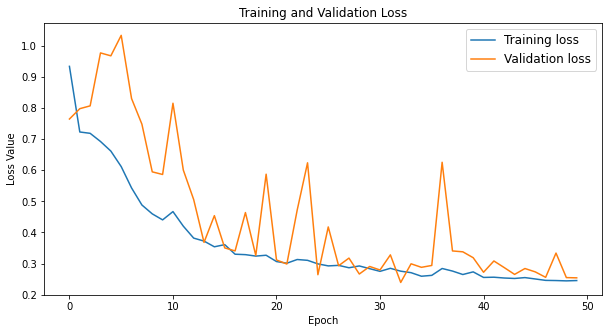

TypeError: ignored

<Figure size 720x360 with 0 Axes>

In [ ]:
weight_path = path + 'models_checkpoints/'+ "{}-gender={}-epochs={}_weights.best.hdf5".format(model_name, 'Female', epochs)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('training_Female.log', append=True)
callbacks = [checkpoint, CustomCallback(), csv_logger]

incV3_F_history, incV3_F_time = fit_boneage(incV3_F, train_gen_F, train_steps_F, val_gen_F, val_steps_F,
                                            epochs, callbacks, 'Female')

## Model evaluation

In [36]:
model_name = 'incV3'
gender = True

weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
model = create_model(model_name, (IMG_SIZE, IMG_SIZE, 1), 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)
model.load_weights(weight_path)

In [37]:
test_X, test_Y = next(test_gen)
pred_Y = std_bone_age * model.predict(test_X, batch_size = batch_size, verbose = True) + mean_bone_age
test_Y_months = std_bone_age * test_Y + mean_bone_age

Found 200 validated image filenames.
Found 200 validated image filenames.
7/7 [==============================] - 23s 3s/step


Text(0, 0.5, 'Predicted Age (Months)')

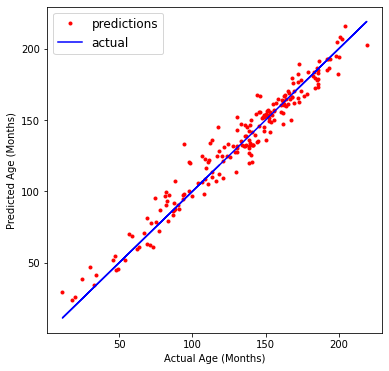

In [38]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y_months, pred_Y, 'r.', label = 'predictions')
ax1.plot(test_Y_months, test_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

Good results but there are few predictions that are way out of the line. This is probably due to images to which the contrast resulted in a bad image and the mask and consequently masked version are bad. Let's verify it.

In [39]:
miss = pred_Y.T - test_Y_months
print(miss.argmax(), miss.max())
print(miss.argmin(), miss.min())

181 38.744114254960934
184 -20.35111542805612


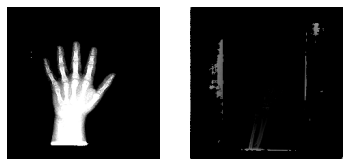

In [ ]:
fig, ax = plt.subplots(1, 2)
[a.axis('off') for a in ax.flatten()]

img1 = cv2.cvtColor(test_X[0][miss.argmax()],cv2.COLOR_GRAY2RGB)
img2 = cv2.cvtColor(test_X[0][miss.argmin()],cv2.COLOR_GRAY2RGB)
ax[0].imshow(img1)
ax[1].imshow(img2)

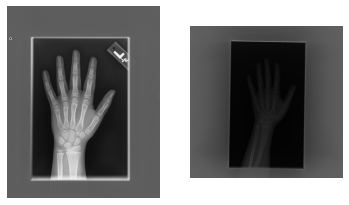

In [ ]:
fig, ax = plt.subplots(1, 2)
[a.axis('off') for a in ax.flatten()]

img1 = cv2.imread(test_path + 'Test Set Images/' + test_df.loc[miss.argmax(), 'image'].split('/')[-1])
img2 = cv2.imread(test_path + 'Test Set Images/' + test_df.loc[miss.argmin(), 'image'].split('/')[-1])
ax[0].imshow(img1)
ax[1].imshow(img2)

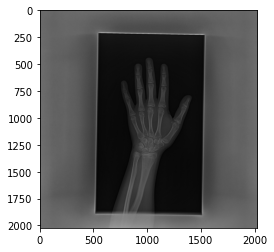

In [ ]:
#Creating CLAHE 
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))

#Apply CLAHE to the original image
image = cv2.imread(test_path + 'Test Set Images/' + name)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image_clahe = clahe.apply(image)
image_clahe = cv2.cvtColor(image_clahe, cv2.COLOR_GRAY2RGB)
plt.imshow(image_clahe)

In [ ]:
# Evaluate the model
loss, mae, accuracy = model.evaluate(test_gen, verbose=2, steps=1)

1/1 - 21s - loss: 0.2153 - mae_in_months: 8.8660 - accuracy: 0.0000e+00 - 21s/epoch - 21s/step


Visualize predictions

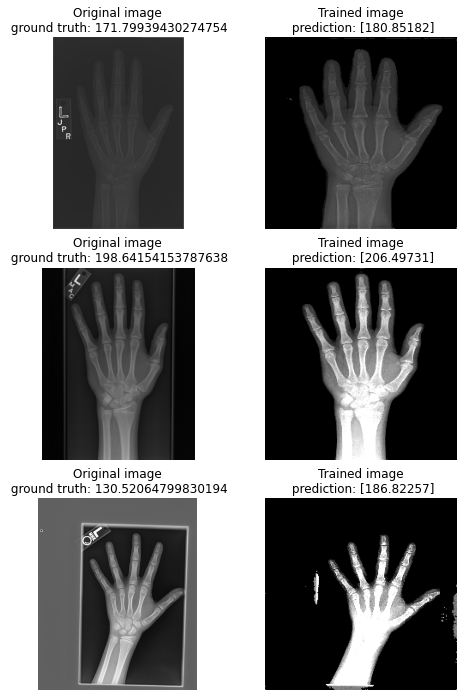

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(8, 12))
[ax.axis('off') for ax in axs.flatten()]

indexes = np.random.randint(0, test_df.shape[0], size=4)
for i, ax in enumerate(axs):
  ind = indexes[i]
  name = test_df.loc[ind, 'image'].split('/')[-1]
  original = cv2.imread(test_path + 'Test Set Images/' + name)
  # original = cv2.imread(test_path + 'Test Set Images Contrast/' + name)
  masked = cv2.imread(test_df.loc[ind, 'image'])

  ax[0].imshow(original)
  ax[1].imshow(masked)
  ax[0].set_title('Original image\n ground truth: {}'.format(test_Y_months[ind]))
  ax[1].set_title('Trained image\n prediction: {}'.format(pred_Y[ind]))

### R2 score

R2 indicates the proportion of data points which lie within the line created by the regression equation. A higher value of R2 is desirable as it indicates better results.

R2= 1- SSres / SStot

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(test_Y_months, pred_Y)
r2

0.8612577860291909

## Model comparison

In [ ]:
from sklearn.metrics import r2_score

def load_model_data(model_name, weight_path, logs_path, t_gen, gender=True):
  # create and load model's best version
  model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)
  model.load_weights(path + 'models_checkpoints/' + weight_path)
  # load training data
  logs = pd.read_csv(path + logs_path)
  # model params
  params = model.count_params()
  # evaluate model (loss, mae)
  test_eval = model.evaluate(t_gen, verbose=0, steps=1)
  
  # compute predictions
  input, g_truth = next(t_gen)
  pred = std_bone_age * model.predict(input, batch_size = batch_size, verbose=False) + mean_bone_age
  g_truth = std_bone_age * g_truth + mean_bone_age
  # R2 score
  r2 = r2_score(g_truth, pred)

  return model, logs, params, test_eval, r2

In [ ]:
incV3 = create_model('incV3', IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months)
incV3.load_weights(path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format('incV3'))
incV3_time = 7889.224729299545
incV3_params = incV3.count_params()
incV3_loss = 0.1966
incV3_mae = 8.0964
incV3_val_loss = 0.1941 
incV3_val_mae = 7.9953
incV3_test = model.evaluate(test_gen, verbose=0, steps=1)
incV3_r2 = r2_score(test_Y_months, pred_Y)

In [ ]:
# incV3, incV3_logs, incV3_params = load_model_data('incV3', "{}_weights.best.hdf5".format('incV3'), 'training.log')
incV3M, incV3M_logs, incV3M_params, incV3M_test, incV3M_r2 = load_model_data('incV3', "{}-gender={}-epochs={}_weights.best.hdf5".format('incV3', 'Male', epochs), 
                                                     'training_Male.log', test_gen_M, gender=False)
incV3F, incV3F_logs, incV3F_params, incV3F_test, incV3F_r2 = load_model_data('incV3', "{}-gender={}-epochs={}_weights.best.hdf5".format('incV3', 'Female', epochs), 
                                                     'training_Female.log', test_gen_F, gender=False)
incV4, incV4_logs, incV4_params, incV4_test, incV4_r2 = load_model_data('incV4', "{}_weights.best.hdf5".format('incV4'),
                                                  'training_incV4.log', test_gen)

7/7 [==============================] - 41s 6s/step


In [ ]:
# changing matplotlib.pyplot style
plt.style.use('ggplot') # R like
# plt.style.use('bmh')
# plt.style.use('fivethirtyeight')
# plt.style.use('default')

In [ ]:
def plot_bars(values, color, title, xlabel, ylabel, values_2=None, values_3=None):
  # bars = ['incV3', 'incV4', 'simple_conv', 'vgg16']
  bars = ['incV3', 'incV3 Male', 'incV3 Female', 'incV4']
  x_pos = np.arange(len(bars))
  
  if values_3:
    # plot data in grouped manner of bar type
    plt.bar(x_pos-0.3, values, 0.3, color=colors[0])
    plt.bar(x_pos, values_2, 0.3, color=colors[2])
    plt.bar(x_pos+0.3, values_3, 0.3, color=colors[3])
    plt.legend(['train', 'validation', 'test'])
  elif values_2:
    # plot data in grouped manner of bar type
    plt.bar(x_pos-0.2, values, 0.4, color=colors[1])
    plt.bar(x_pos+0.2, values_2, 0.4, color=colors[3])
    plt.legend(['train', 'validation'])
  else:
    plt.bar(x_pos, values, color=colors)

  plt.xticks(x_pos, bars)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  # plt.legend(["Round 1", "Round 2", "Round 3"])
  plt.show()

Plot #parameters

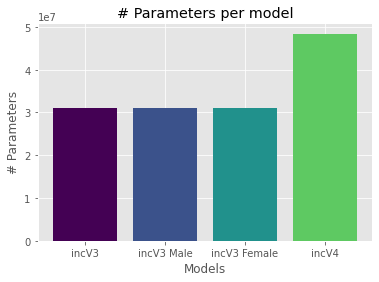

In [ ]:
# num_params = [incV3_model.count_params(), incV4_model.count_params(), 
#               simple_conv_model.count_params(), vgg16_model.count_params()]

num_params = [incV3_params, incV3M_params, incV3F_params, incV4_params]

plot_bars(num_params, colors, '# Parameters per model', 'Models', '# Parameters')

Plot training time

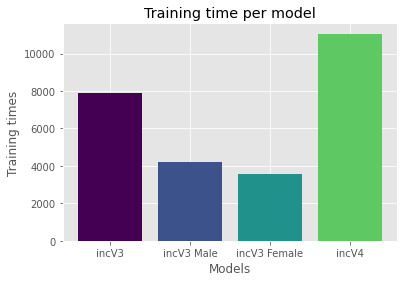

In [ ]:
tr_times = [incV3_time, list(incV3M_logs['train_time'])[-1],
            list(incV3F_logs['train_time'])[-1], list(incV4_logs['train_time'])[-1]]

plot_bars(tr_times, colors, 'Training time per model', 'Models', 'Training times')

Plot accuracy/loss

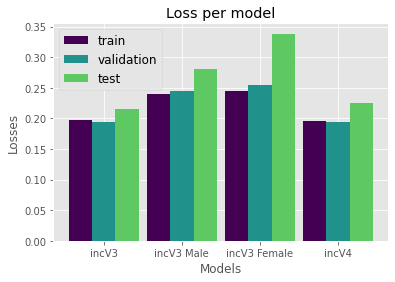

In [ ]:
losses = [incV3_loss, list(incV3M_logs['loss'])[-1], 
          list(incV3F_logs['loss'])[-1], list(incV4_logs['loss'])[-1]]
val_losses = [incV3_val_loss, list(incV3M_logs['val_loss'])[-1], 
          list(incV3F_logs['val_loss'])[-1], list(incV4_logs['val_loss'])[-1]]
test_losses = [incV3_test[0], incV3M_test[0], incV3F_test[0], incV4_test[0]]

plot_bars(losses, colors, 'Loss per model', 'Models', 'Losses', val_losses, test_losses)

We can also see how does it change the graph when Male and Female models are evaluated with all test dataset

In [ ]:
test_eval_M = incV3M.evaluate(test_gen, verbose=0, steps=1)
test_eval_F = incV3F.evaluate(test_gen, verbose=0, steps=1)

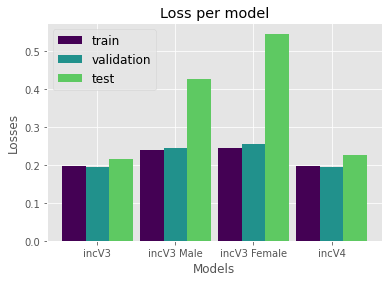

In [ ]:
test_losses2 = [incV3_test[0], test_eval_M[0], test_eval_F[0], incV4_test[0]]

plot_bars(losses, colors, 'Loss per model', 'Models', 'Losses', val_losses, test_losses2)

Plot MAE

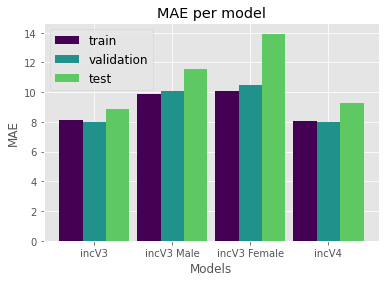

In [ ]:
maes = [incV3_mae, list(incV3M_logs['mae_in_months'])[-1], 
        list(incV3F_logs['mae_in_months'])[-1], list(incV4_logs['mae_in_months'])[-1]]
val_maes = [incV3_val_mae, list(incV3M_logs['val_mae_in_months'])[-1], 
            list(incV3F_logs['val_mae_in_months'])[-1], list(incV4_logs['val_mae_in_months'])[-1]]
test_maes = [incV3_test[1], incV3M_test[1], incV3F_test[1], incV4_test[1]]

plot_bars(maes, colors, 'MAE per model', 'Models', 'MAE', val_maes, test_maes)

Plot R2 score

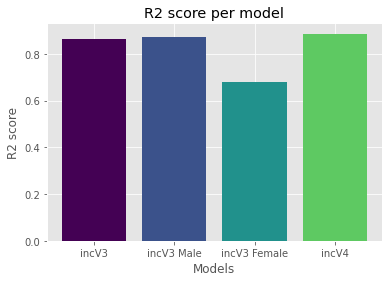

In [ ]:
r2s = [incV3_r2, incV3M_r2, incV3F_r2, incV4_r2]

plot_bars(r2s, colors, 'R2 score per model', 'Models', 'R2 score')

Plot memory

In [ ]:
import sys

incV3_memory = sys.getsizeof(incV3_model)
incV4_memory = sys.getsizeof(incV4_model)
simple_conv_memory = sys.getsizeof(simple_conv_model)
vgg16_memory = sys.getsizeof(vgg16_model)
memories = [incV3_memory, incV4_memory, simple_conv_memory, vgg16_memory]

plot_bars(memories, colors, 'Memory occupied per model', 'Models', 'Memory occupied')

In [ ]:
def plot_bubbles(models, x, y, z, xlabel, ylabel):
  fig, _ = plt.subplots(figsize=(8, 5))
  plt.scatter(x = x, y = y, s=z/10000, c=colors, 
              alpha=0.6, edgecolors="white", linewidth=2)
  
  # plt.xlim(0, 12000)
  plt.ylim(0.1, 0.3)
  # plt.yscale('log')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  # plt.legend(["Round 1", "Round 2", "Round 3"])
  for i, txt in enumerate(models):
    plt.annotate(txt, (x[i] - 300, y[i]))
  plt.show()

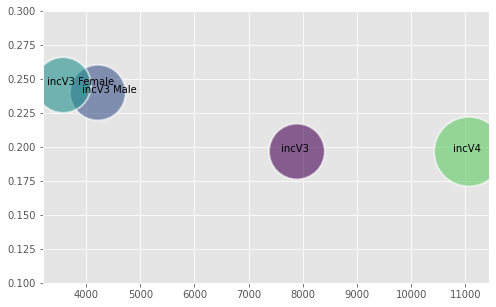

In [ ]:
models = ['incV3', 'incV3 Male', 'incV3 Female', 'incV4']
plot_bubbles(models, np.array(tr_times), np.array(losses), np.array(num_params), '', '')

## Attention mechanism
In this case we use again the VGG16 model, this time pretrained with the imagenet weights, and add an attention layer.

This attention layer is exploited to retrieve (hopefully) the most relevant parts of the image which influence the most the training.

In [ ]:
from keras.applications.xception import Xception
from keras.layers import LocallyConnected2D, GlobalAveragePooling2D, Lambda, multiply

X_input = Input((IMG_SIZE, IMG_SIZE, 3)) # (224, 224, 3)

# vgg16 = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
# vgg16.trainable = False
# X = vgg16(X_input)
# vgg16_shape = vgg16.get_output_shape_at(0)[-1]
xception = Xception(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False)
X = xception(X_input)
xception_shape = xception.get_output_shape_at(0)[-1]
X = BatchNormalization()(X)

# here we do an attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(64, kernel_size=1, padding='same', activation='relu')(X)
attn_layer = Conv2D(16, kernel_size=1, padding='same', activation='relu')(attn_layer)
attn_layer = LocallyConnected2D(1, kernel_size=1, padding='valid', activation='sigmoid')(attn_layer)

# fan it out to all of the channels
# upscale_w = np.ones((1, 1, 1, vgg16_shape))
# upscale = Conv2D(vgg16_shape, kernel_size=1, padding='same', activation='linear',
#                   use_bias=False, weights=[upscale_w])
upscale_w = np.ones((1, 1, 1, xception_shape))
upscale = Conv2D(xception_shape, kernel_size=1, padding='same', activation='linear',
                  use_bias=False, weights=[upscale_w])
upscale.trainable = False
attn_layer = upscale(attn_layer)

X = multiply([attn_layer, X])
X = GlobalAveragePooling2D()(X)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# to account for missing values from the attention model
X = Lambda(lambda x: x[0]/x[1], name='RescaleGAP')([X, gap_mask])
X = Dropout(0.5)(X)
X = Dropout(0.25)(Dense(1024, activation ='elu')(X))

X = Dense(1, activation='linear')(X)
attention_model = Model(inputs=X_input, outputs=X)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
# attention_model = Attention_vgg16((IMG_SIZE, IMG_SIZE, 3))
# attention_model.compile(loss='mse', optimizer='adam', metrics=[mae_in_months])
attention_model.compile(loss='mae', optimizer='adam', metrics=[mae_in_months])

In [ ]:
# create generators without merging, with gender data and with rgb images

train_gen = datagen_train.flow_from_dataframe(dataframe=train_df,
        x_col='image', y_col='boneage_n', batch_size=batch_size, seed=1, shuffle=True, class_mode='other',
        target_size=(IMG_SIZE, IMG_SIZE), color_mode='rgb', drop_duplicates=False)
val_gen = datagen_val.flow_from_dataframe(dataframe=validation_df,
        x_col='image', y_col='boneage_n', batch_size=batch_size, seed=1, shuffle=True, class_mode='other',
        target_size=(IMG_SIZE, IMG_SIZE), color_mode='rgb', drop_duplicates=False)

Found 12611 validated image filenames.
Found 1425 validated image filenames.


In [ ]:
weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format('attention')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/training_attention.log', append=True)
callbacks = [checkpoint, CustomCallback(), csv_logger]

attention_model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks)

Epoch 1/50
  6/395 [..............................] - ETA: 3:48 - loss: 1.8197 - mae_in_months: 74.9370

395/395 [==============================] - ETA: 0s - loss: 0.5478 - mae_in_months: 22.5594
Epoch 1: val_loss improved from inf to 0.54267, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/attention_weights.best.hdf5
395/395 [==============================] - 280s 669ms/step - loss: 0.5478 - mae_in_months: 22.5594 - val_loss: 0.5427 - val_mae_in_months: 22.3482 - train_time: 281.2030
Epoch 2/50
395/395 [==============================] - ETA: 0s - loss: 0.3938 - mae_in_months: 16.2195
Epoch 2: val_loss improved from 0.54267 to 0.30442, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/attention_weights.best.hdf5
395/395 [==============================] - 264s 668ms/step - loss: 0.3938 - mae_in_months: 16.2195 - val_loss: 0.3044 - val_mae_in_months: 12.5368 - train_time: 545.4417
Epoch 3/50
395/395 [==============================] - ETA: 0s - loss: 0.3692 - mae_in_months: 1

KeyboardInterrupt: ignored

Show attention maps

In [ ]:
for attn_layer in attention_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

(224, 224, 3)
1/1 [==============================] - 1s 1s/step
(224, 224, 3)
1/1 [==============================] - 0s 34ms/step
(224, 224, 3)
1/1 [==============================] - 0s 31ms/step


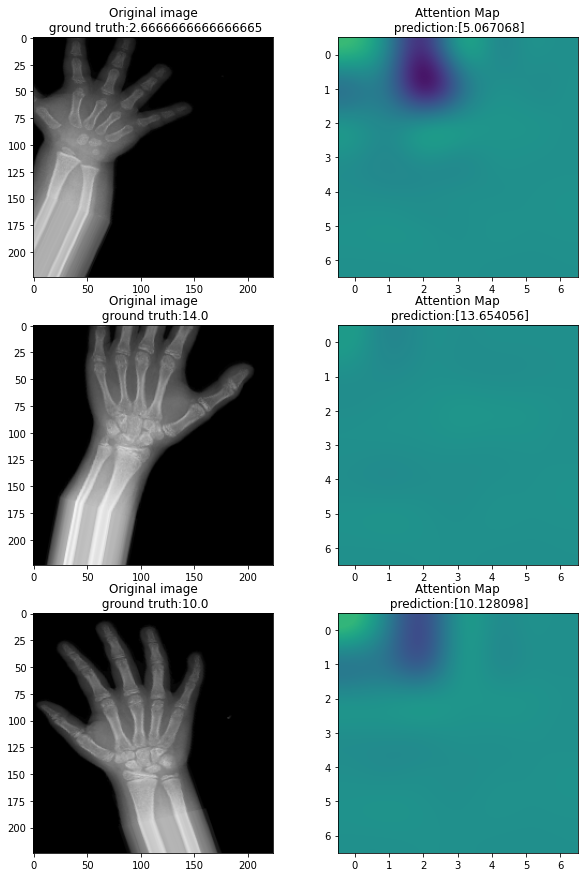

In [ ]:
import keras.backend as K

attn_func = K.function(inputs = [attention_model.layers[0].get_input_at(0)], outputs = [attn_layer.get_output_at(0)])

fig, axs = plt.subplots(3, 2, figsize = (10, 15))
# [ax.axis('off') for ax in axs.flatten()]

# img_batch, val_batch = next(train_gen)
img_batch, val_batch = train_gen[0]
attn_img_batch = attn_func([img_batch])[0]
# for i in [0, 1, 2]:
#     img = img_batch[i]
#     val = val_batch[i]
#     attn_img = attn_img_batch[i]
#     # img_ax.imshow(img[:,:,0], cmap = 'bone')
#     # axs[i][2*i + 1].imshow(attn_img[:, :, 0], cmap = 'viridis', vmin = 0, vmax = 1, interpolation = 'lanczos')
#     axs[i][2*i].imshow(img)
#     axs[i][2*i + 1].imshow(attn_img, cmap='viridis')
#     axs[i][2*i].axis('off')
#     axs[i][2*i + 1].axis('off')

    # g_truth = std_bone_age * val + mean_bone_age
    # axs[i][2*i].set_title('Original image\n ground truth:{}'.format(g_truth/12))
    # pred = std_bone_age * attention_model.predict(img) + mean_bone_age
    # axs[i][2*i + 1].set_title('Attention Map\n prediction:{}'.format(pred[i]/12))

for i, (img_ax, attn_ax) in zip([0, 1, 2], axs):
    img = img_batch[i]
    val = val_batch[i]
    attn_img = attn_img_batch[i]
    # img_ax.imshow(img[:,:,0], cmap = 'bone')
    img_ax.imshow(img)
    attn_ax.imshow(attn_img[:, :, 0], cmap = 'viridis', vmin = 0, vmax = 1, interpolation = 'lanczos')

    print(img.shape)

    g_truth = std_bone_age * val + mean_bone_age
    img_ax.set_title('Original image\n ground truth:{}'.format(g_truth/12))
    pred = std_bone_age * attention_model.predict(img_batch) + mean_bone_age
    attn_ax.set_title('Attention Map\n prediction:{}'.format(pred[i]/12))
